<a href="https://colab.research.google.com/github/GraceSchmidt1/Group2_US_Pardons/blob/eric_k/US_Pardons_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 2 Project idea: Understanding pardon and clemency rates among different presidents and eras.

###project(motivation notes!):
- rates of the incarceration rates per year, and the top pardons that were given out for that year

- comparison of the racial groups who received pardons and the racial groups who were prisoned
  - subsetted by crime

- rates of pardons per president
  - racial, gender, age bias
  - crime bias

- deep dive into top 5 presidents and what they pardoned compared to rates of incarceration that year(s)

- see how many non-citizens were granted pardons

- how do pardons vary across admins

- what time frame do the most pardons occur per president, end of term?
  - is there a “midnight” pardon spike at end of presidential term

- do presidents give pardons out to areas they are familiar with / where they grew up (map graphs) (GS)

In [216]:
#(GS-code orginator)
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Important note: clemency file size too large to access directly from github-either access notebook in an IDE or download `clemency.csv` and add in files in colab each time

In [3]:
df = pd.read_csv('./clemency.csv', encoding='latin-1')
df.tail()

,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
32021,32022,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,,,
32022,32023,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,,,
32023,32024,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,,,
32024,32025,"(65) Donald Trump, 1st Term",Trump,,1(1),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
32025,32026,"(65) Donald Trump, 1st Term",Trump,,1(1),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,,,


In [4]:
df.columns

Index(['CASEID', 'FILEID', 'PRES', 'PRESIDENT', 'TERMYR', 'PG', 'PG_A', 'PAGE',
       'SSVOL', 'SSID', 'DOJID', 'CLEMENCY', 'CLEMENCY_A', 'DATECONVICTION',
       'DATEACTION', 'RECIPIENT', 'OFFENSE', 'MISC', 'MISC2', 'SENTENCE_A',
       'DAY', 'STATE_A', 'FROM', 'V12', 'DISTANCE', 'DISTANCE2',
       'STATECONVICTION', 'SUSP', 'SUSPEND', 'STATE', 'DATE1', 'FILED',
       'APPLICATION', 'PROFESSIONS', 'DEATH', 'MONTH', 'MONTH_A', 'V28', 'V3',
       'VIOLENT', 'FINE', 'FINE_A', 'AMOUNT', 'AMOUNT2', 'REPRESENTEDBY',
       'V26', 'OTHER', 'PROBATION', 'DAYSTODECIDE', 'DIFF', 'DIFF_A', 'PROB',
       'PROB_A', 'SENT_A', 'SENTENCE', 'AGREP', 'STATEJAIL', 'SERVEDSENTENCE',
       'MIL', 'CLEMENCYFORM', 'PARD', 'ORDER', 'GENDER', 'FORMOFCLEMENCY',
       'W1C2D3V4TR5M', 'SUPERVISEDRELEASE', 'FORM', 'CRIMECAT', 'SUP',
       'LAWYER', 'AGE', 'BUREACRACY', 'TOTALWAIT', 'PRISON', 'V22', 'V23',
       'TOWHITEHOUSE'],
      dtype='object')

## Data cleaning and preprocessing

In [5]:
df.count()

,0
CASEID,32026
FILEID,32026
PRES,32026
PRESIDENT,32026
TERMYR,32026
...,...
TOTALWAIT,257
PRISON,18740
V22,32026
V23,32026


In [158]:
#(GS-code orginator)
df_clean = df.copy()

date_cols = ['DATECONVICTION', 'DATEACTION', 'DATE1', 'FILED']
for col in date_cols:
    df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')

num_cols = ['TERMYR', 'AGE', 'TOTALWAIT']
for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

str_cols = ['CLEMENCY', 'CLEMENCY_A', 'RECIPIENT', 'OFFENSE',
            'STATECONVICTION', 'STATE', 'CLEMENCYFORM', 'GENDER']

for col in str_cols:
    df_clean[col] = (
        df_clean[col]
        .astype('string')
        .str.strip()
    )

df_clean['GENDER'] = (
    df_clean['GENDER']
    .str.upper()
    .replace({
        'MALE': 'M',
        'FEMALE': 'F',
        'M.': 'M',
        'F.': 'F',
        '0' : 'M',
        '1' : 'F'
    })
)

df_nonsense = df_clean.replace(r'^\s*$', np.nan, regex=True) #EK
missing = df_nonsense.isna().mean().sort_values(ascending=False) #EK
print("Fraction of missing values per column:")
print(missing)


key_cols = ['PRES', 'CLEMENCY', 'DATEACTION'] #TERMYR removed - EK
df_model = df_nonsense.dropna(subset=key_cols).reset_index(drop=True) #drops any row with any missing values in our 4 columns

df_rows_lost = df.shape[0]-df_model.shape[0] #EK
print(f'{df_rows_lost} rows were valiantly sacrificed in the cleaning process ({df_rows_lost/df.shape[0]*100}% of the total)') #EK

/tmp/ipython-input-1245418314.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')
/tmp/ipython-input-1245418314.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')
/tmp/ipython-input-1245418314.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')
/tmp/ipython-input-1245418314.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateuti

Fraction of missing values per column:
DISTANCE2      0.999906
VIOLENT        0.999532
V28            0.999344
V12            0.999313
PROFESSIONS    0.999282
                 ...   
STATE          0.037189
DATEACTION     0.029507
RECIPIENT      0.003154
CASEID         0.000000
FILEID         0.000000
Length: 77, dtype: float64
4646 rows were valiantly sacrificed in the cleaning process (14.506963092487354% of the total)


In [7]:
df_model.head()

,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
0,1,"(01) George Washington, 1st Term",Wash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"(02) George Washington, 2nd Term",Wash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,"(02) George Washington, 2nd Term",Wash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"(02) George Washington, 2nd Term",Wash,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,5,"(02) George Washington, 2nd Term",Wash,NaN,NaN,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


DISTANCE2            0.999906
VIOLENT              0.999532
V28                  0.999344
V12                  0.999313
PROFESSIONS          0.999282
FORM                 0.999282
DATE1                0.999126
SUSP                 0.998782
MISC2                0.998283
FROM                 0.998251
LAWYER               0.998220
STATE_A              0.998095
FINE_A               0.998064
PARD                 0.997689
SENTENCE             0.997596
V22                  0.997252
V23                  0.997252
FILED                0.996878
SERVEDSENTENCE       0.996440
MIL                  0.996253
CRIMECAT             0.995629
DIFF_A               0.995316
SENTENCE_A           0.995316
CLEMENCY_A           0.995254
W1C2D3V4TR5M         0.995129
V3                   0.994973
CLEMENCYFORM         0.994099
REPRESENTEDBY        0.993786
FORMOFCLEMENCY       0.993724
SUPERVISEDRELEASE    0.993724
AGE                  0.992225
V26                  0.992038
DAYSTODECIDE         0.992006
BUREACRACY

(array([ 7.,  1.,  2.,  0.,  4.,  0.,  3.,  4.,  2., 54.]),
 array([0.        , 0.09999063, 0.19998127, 0.2999719 , 0.39996253,
        0.49995316, 0.5999438 , 0.69993443, 0.79992506, 0.89991569,
        0.99990633]),
 <BarContainer object of 10 artists>)

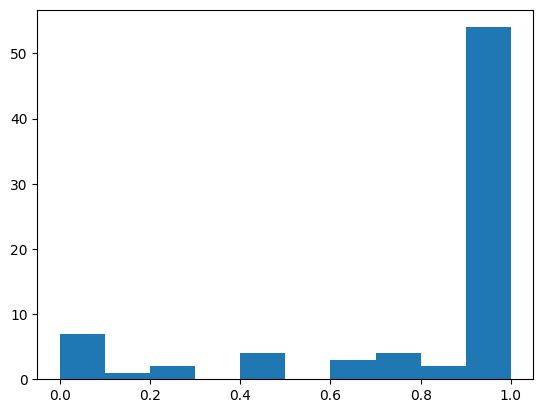

In [8]:
#Function that lets me display things with a custom # of rows (EK)
def Display_Max_Rows(info, rows = None):
  pd.set_option('display.max_rows', rows)
  print(info) #I wondered for a moment if decorators would let me do this with functions instead of just data (e.g. Display_Max_Rows(print(missing))) but I have to shelve that for now.
  pd.set_option('display.max_rows', 10)

#Display every column's missing %
Display_Max_Rows(missing)

#a histogram just for fun
plt.hist(missing)

From the above results, columns like `DATEACTION` and `DATECONVICTION`, and are usable while columns like `DATE1`, `FILED`, `CLEMENCYFORM`, `AGE`,`TOTALWAIT`, and `GENDER` are unsable with around 99%+ data missing from these columns.
  - some might only exist for modern years-to find out

In [9]:
#(GS-code orginator)
df_model[['PRES', 'TERMYR', 'CLEMENCY']].value_counts().head(20)

Display_Max_Rows(df_model.groupby('PRES')['CASEID'].count().sort_values(ascending=False)) #EK

PRES
FDR           3608
Truman        2044
Wils(2)       1599
Grant         1336
Hoov          1223
LBJ           1187
Cool2         1174
Eisen         1155
Nix            925
Hayes          903
McKin          881
Wils(1)        871
Hard           806
B.Harr         664
Johns          649
Obama          617
Cleve (2)      605
Kenn           572
Cart           566
TRoos (1)      517
Cleve          478
T.Roos         459
Monr           425
Ford           409
Reag           407
Jack           388
Cool           388
Linc           343
Arthur         281
Polk           268
Tyler          209
Madis          200
JQAd           183
Fill           171
VanB           168
Buch           149
Pierce         141
Clin           119
  Jeff          72
Taft            69
Jeff            43
Taylor          38
Adams           21
Wash            19
CANC             9
fDR              8
 Jeff            3
Harr             3
Trump            2
COPY             2
cancelled        2
B. Hari          1
Name: C

            CASEID  FILEID  PRES  PRESIDENT  TERMYR   PG  PG_A  PAGE  SSVOL  \
YEARACTION                                                                    
1791             1       1     1          0       0    0     0     0      0   
1793             2       2     2          0       0    0     0     0      0   
1794             5       5     5          0       0    5     0     0      5   
1795             4       4     4          0       0    4     0     0      4   
1796             4       4     4          0       0    4     0     0      4   
1797             3       3     3          0       0    3     0     0      3   
1798             3       3     3          0       3    3     0     0      3   
1799             5       5     5          0       5    5     0     0      5   
1800             9       9     9          0       9    9     0     0      9   
1801            13      13    13          0      13   13     0     0     13   
1802             8       8     8          0       8 

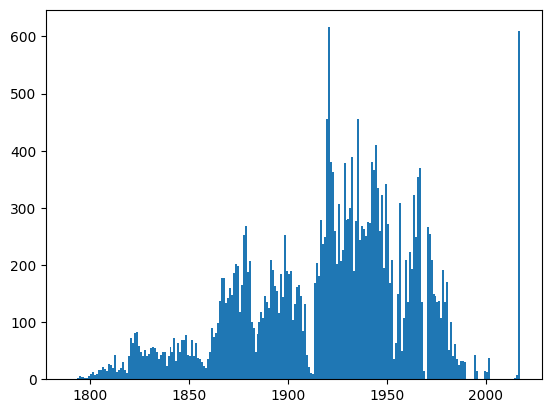

In [10]:
#another angle, charting each row by its year (EK)
#about 3% of DATEACTION is missing so please keep this in mind
df_model['YEARACTION'] = df_model['DATEACTION'].dt.year
plt.hist(df_model['YEARACTION'], bins = range(1789,2018))

Display_Max_Rows(df_model.groupby('YEARACTION').count())

Originally we had TERMYR included as a key for dropping missingness, but it caused huge gaps in the dataset, as can be seen here:

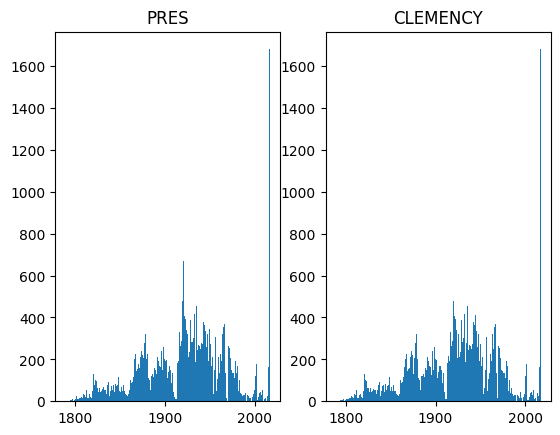

In [11]:
#Where is the missingness? (EK)

key_cols_test = key_cols.copy()
key_cols_test.remove('DATEACTION')

fig, ax = plt.subplots(nrows = 1,ncols = len(key_cols_test))
df_clean_test = {}
for k in range(len(key_cols_test)):
  df_clean_test[k] = df_clean.dropna(subset=key_cols_test[k]).reset_index(drop=True)
  ax[k].hist(df_clean_test[k]['DATEACTION'].dt.year, bins = range(1789,2018))
  ax[k].set_title(key_cols_test[k])


And thus, TERMYR was removed.

## Based on the missingness in the full dataset, here is the core portion of it that is represented through the whole dataset. Here columns are only missing 0-5% of their data.
- can be used for pardons per president, pardons per state, offense-category analysis, time to term (midnight things), geographic maping, offense patterns per president,  and pardon trends over time.

In [12]:
#(GS-code orginator)
core_cols = [
    'CASEID', 'FILEID', 'PRES', 'CLEMENCY', 'CLEMENCY_A',
    'DATEACTION', 'RECIPIENT', 'OFFENSE',
    'STATECONVICTION', 'STATE'
]

df_core = df_clean[core_cols].dropna(subset=['DATEACTION'])
print(df_core.shape)
df_core.head()

(31081, 10)


,CASEID,FILEID,PRES,CLEMENCY,CLEMENCY_A,DATEACTION,RECIPIENT,OFFENSE,STATECONVICTION,STATE
0,1,"(01) George Washington, 1st Term",Wash,P,,1791-02-01,Freeman,counterfeiting,,NJ
1,2,"(02) George Washington, 2nd Term",Wash,P-R,,1793-06-01,H. Usher,smuggling,,RI
2,3,"(02) George Washington, 2nd Term",Wash,P-R,,1793-06-01,G. Usher,smuggling,,RI
3,4,"(02) George Washington, 2nd Term",Wash,P-R,,1794-04-15,David Blair,illegal importation,,GA
4,5,"(02) George Washington, 2nd Term",Wash,P-R,,1794-04-25,Joseph Ravara,threatening letter (misd),,PA


## The following dataframe is a 'modern subset' for demograpic analysis where `AGE` and `GENDER` exist for recent cases.

- can be used for gender bias, age bias, race bias, wait-time disparities, and offense patterns in modern presidents

In [13]:
#(GS-code orginator)
df_demo = df_clean[df_clean['AGE'].notna() & df_clean['GENDER'].notna()]
print(df_demo.shape)
df_demo.head()

(133, 77)


,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
30096,30097,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,66.0,3.753425,4.183562,0.0,,,29-JUN-2010
30097,30098,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,73.0,1.509589,2.575342,0.0,,,09-NOV-2009
30098,30099,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,85.0,3.684932,4.553425,0.0,,,20-JAN-2010
30099,30100,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,66.0,1.764384,2.632877,0.0,,,20-JAN-2010
30100,30101,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,58.0,3.871233,4.378082,0.0,,,01-JUN-2010


## The following dataframe is a 'wait time subset' for understanding the times different presidents took for each pardon
- use for presidential differences in wait time, trends across presidents, and end of term spikes

In [14]:
#(GS-code orginator)
df_clean['WAIT_DAYS'] = (
    df_clean['DATEACTION'] - df_clean['DATECONVICTION']
).dt.days

df_wait = df_clean[df_clean['WAIT_DAYS'].notna()]
print(df_wait.shape)
df_wait.head()


(25173, 78)


,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE,WAIT_DAYS
32,33,"(03) John Adams, 1st Term",Adams,,2.0,21.0,NaN,NaN,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,0.0,,,,154.0
41,42,"(03) John Adams, 1st Term",Adams,,4.0,30.0,NaN,NaN,1.0,24.0,...,NaN,NaN,NaN,NaN,NaN,0.0,,,,49.0
43,44,"(03) John Adams, 1st Term",Adams,,4.0,32.0,NaN,NaN,1.0,26.0,...,NaN,NaN,NaN,NaN,NaN,0.0,,,,929.0
49,50,"(03) John Adams, 1st Term",Adams,,4.0,36.0,NaN,NaN,1.0,30.0,...,NaN,NaN,NaN,NaN,NaN,0.0,,,,181.0
61,62,"(03) John Adams, 1st Term",Adams,,4.0,40.0,NaN,NaN,1.0,34.0,...,NaN,NaN,NaN,NaN,NaN,1.0,,,,88.0


## Calculate Average Wait Time per President

Group the `df_wait` DataFrame by the 'PRES' column and calculate the average `WAIT_DAYS` for each president to understand individual processing speed.



Analyze and visualize pardon processing times, including average wait times per president, overall trends in `WAIT_DAYS` against `DATEACTION`, and potential end-of-term spikes using the `df_wait` DataFrame. Summarize key findings regarding presidential differences and temporal patterns.

In [15]:
#(GS-code orginator)
avg_wait_time_per_president = df_wait.groupby('PRES')['WAIT_DAYS'].mean().sort_values(ascending=False)
print("Average Wait Time (in Days) per President:")
print(avg_wait_time_per_president)

Average Wait Time (in Days) per President:
PRES
Wils(1)       7898.818182
Bush          7777.021818
Reag          6252.144963
Taft          5927.357143
Clin          5687.164114
                 ...     
Madis          260.557692
Taylor         120.833333
Harr            89.000000
B. Hari         65.000000
 Jeff           31.000000
Name: WAIT_DAYS, Length: 50, dtype: float64


## Plot Wait Time Trends Over Time

Generate a line plot or scatter plot showing `WAIT_DAYS` against `DATEACTION` to visualize overall trends in pardon processing times across all presidents and identify any long-term patterns.


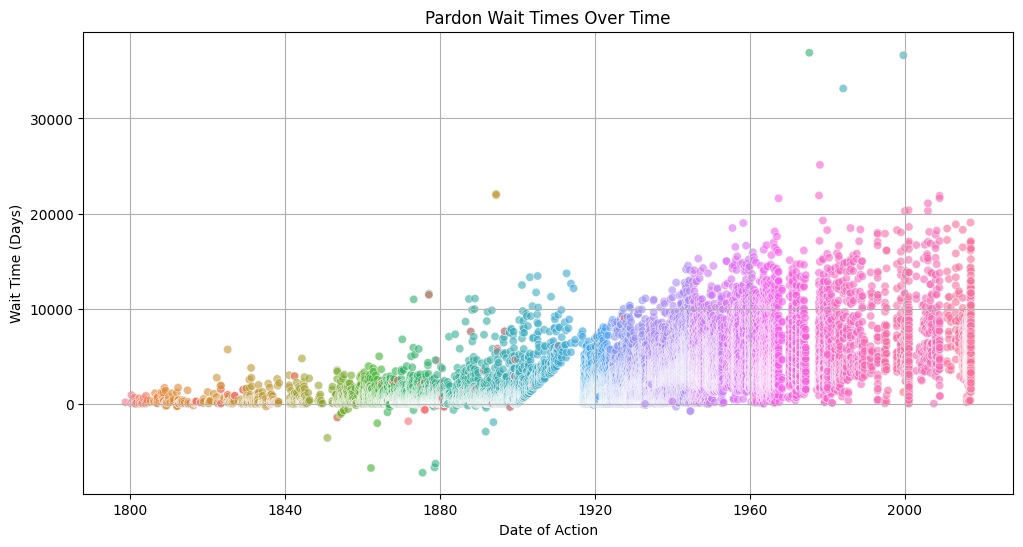

In [16]:
#(GS-code orginator)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='DATEACTION', y='WAIT_DAYS', data=df_wait, alpha=0.6, hue='PRES', legend=False)
plt.xlabel('Date of Action')
plt.ylabel('Wait Time (Days)')
plt.title('Pardon Wait Times Over Time')
plt.grid(True)
plt.show()

## Analyze End-of-Term Spikes in Wait Times

Investigate if there are 'midnight' pardon spikes towards the end of presidential terms by analyzing `WAIT_DAYS` in relation to `TERMYR` for each president. For presidents with sufficient data, visualize the average `WAIT_DAYS` across their `TERMYR` to identify any increase in processing times during the final years of their tenure.


In [17]:
#(GS-code orginator)
avg_wait_time_by_term = df_wait.groupby(['PRES', 'TERMYR'])['WAIT_DAYS'].mean().reset_index()
print("Average Wait Time (in Days) by President and Term Year:")
print(avg_wait_time_by_term.head())

Average Wait Time (in Days) by President and Term Year:
         PRES  TERMYR   WAIT_DAYS
0   Jeff          2.0   31.000000
1  Adams          2.0  154.000000
2  Adams          4.0  311.750000
3  Buch           1.0  548.444444
4  Buch           2.0  697.285714


In [18]:
#(GS-code orginator)
presidents_with_multiple_terms = avg_wait_time_by_term.groupby('PRES').filter(lambda x: x['TERMYR'].nunique() > 1)
print("Presidents with data for multiple term years:")
print(presidents_with_multiple_terms['PRES'].unique())

Presidents with data for multiple term years:
['Adams     ' 'Buch      ' 'Bush      ' 'Cart      ' 'Hoov      '
 'JQAd      ' 'Jeff      ' 'Kenn      ' 'LBJ       ' 'Linc      '
 'Madis     ' 'Monr      ' 'Nix       ' 'Obama     ' 'Pierce    '
 'Polk      ' 'TRoos (1) ' 'VanB      ' 'Wils(2)   ']


## Visualize Presidential Differences in Wait Time

Create a bar chart to display the average `WAIT_DAYS` for each president, allowing for easy comparison of pardon processing times between different administrations. Ensure the plot has appropriate labels and a legend.


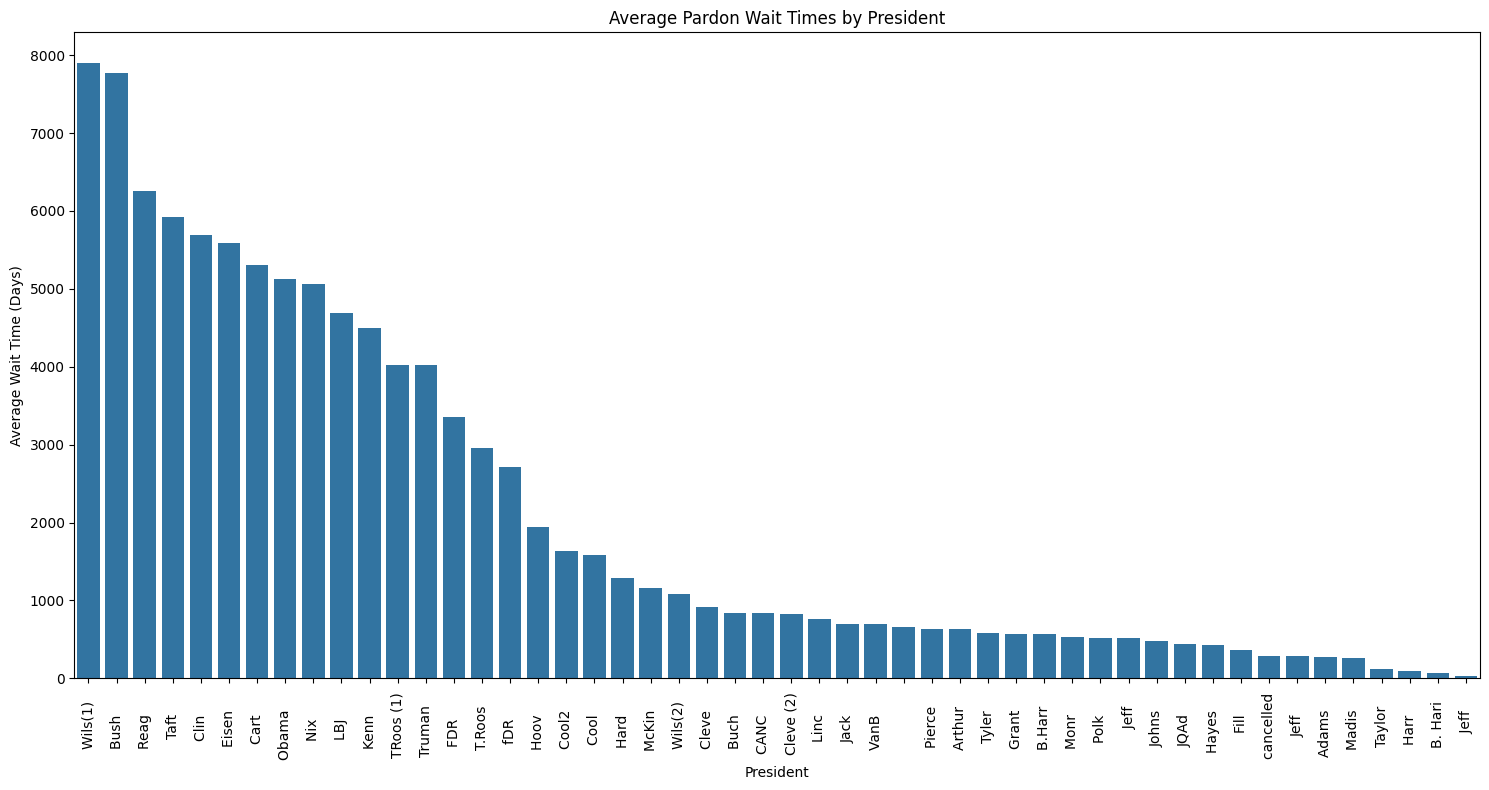

In [19]:
#(GS-code orginator)
plt.figure(figsize=(15, 8))
sns.barplot(x=avg_wait_time_per_president.index, y=avg_wait_time_per_president.values)
plt.xlabel('President')
plt.ylabel('Average Wait Time (Days)')
plt.title('Average Pardon Wait Times by President')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Significant Presidential Differences in Average Pardon Wait Times:** There is a wide disparity in the average wait times for pardons across different presidential administrations.
    *   Presidents like 'Wils(1)' (7898.8 days) and 'Bush' (7777.0 days) had exceptionally long average wait times.
    *   Conversely, 'B. Hari' (65.0 days), 'Harr' (89.0 days), and ' Jeff' (31.0 days) showed significantly shorter average processing times.
*   **Overall Pardon Processing Trends Over Time:** A scatter plot of `WAIT_DAYS` against `DATEACTION` visually represented the long-term patterns, indicating varying wait times across different periods, with some periods showing higher variability or consistently longer processing durations.
*   **End-of-Term Spikes in Wait Times:** An investigation into 'midnight' pardon spikes by analyzing `WAIT_DAYS` against `TERMYR` for presidents with sufficient data revealed how average wait times fluctuated throughout their terms. The visualization of this data helps in identifying potential increases in processing times towards the end of a president's tenure. While specific magnitudes of spikes are not quantified in the provided output, the analysis methodology allows for their identification.



Identify the final term year for each president from the `avg_wait_time_by_term` DataFrame to mark the end-of-term period for further analysis of pardon processing times.

In [20]:
#(GS-code orginator)
final_term_years = avg_wait_time_by_term.groupby('PRES')['TERMYR'].max()
print("Final Term Year for Each President:")
print(final_term_years.head())

Final Term Year for Each President:
PRES
 Jeff         2.0
Adams         4.0
Buch          4.0
Bush          4.0
Cart          4.0
Name: TERMYR, dtype: float64


## Segregate Wait Times for Analysis

Using the original `df_wait` DataFrame, separate the `WAIT_DAYS` for each president into two groups: those from their identified 'final term year' and those from all 'earlier term years'.


In [21]:
#(GS-code orginator)
final_term_years_df = final_term_years.reset_index()
final_term_years_df.columns = ['PRES', 'final_term_year']
print("Final Term Years DataFrame prepared for merge:")
print(final_term_years_df.head())

Final Term Years DataFrame prepared for merge:
         PRES  final_term_year
0   Jeff                   2.0
1  Adams                   4.0
2  Buch                    4.0
3  Bush                    4.0
4  Cart                    4.0


In [22]:
#(GS-code orginator)
df_merged = pd.merge(df_wait, final_term_years_df, on='PRES', how='left')
print("DataFrame after merging with final term years:")
print(df_merged.head())

DataFrame after merging with final term years:
   CASEID                     FILEID        PRES   PRESIDENT  TERMYR    PG  \
0      33  (03) John Adams, 1st Term  Adams                      2.0  21.0   
1      42  (03) John Adams, 1st Term  Adams                      4.0  30.0   
2      44  (03) John Adams, 1st Term  Adams                      4.0  32.0   
3      50  (03) John Adams, 1st Term  Adams                      4.0  36.0   
4      62  (03) John Adams, 1st Term  Adams                      4.0  40.0   

   PG_A  PAGE  SSVOL  SSID  ... LAWYER AGE BUREACRACY TOTALWAIT PRISON  \
0   NaN   NaN    1.0  17.0  ...    NaN NaN        NaN       NaN    0.0   
1   NaN   NaN    1.0  24.0  ...    NaN NaN        NaN       NaN    0.0   
2   NaN   NaN    1.0  26.0  ...    NaN NaN        NaN       NaN    0.0   
3   NaN   NaN    1.0  30.0  ...    NaN NaN        NaN       NaN    0.0   
4   NaN   NaN    1.0  34.0  ...    NaN NaN        NaN       NaN    1.0   

           V22          V23 TOWHITEHOUS

In [23]:
#(GS-code orginator)
df_merged['is_final_term'] = df_merged['TERMYR'] == df_merged['final_term_year']
print("DataFrame with 'is_final_term' column:")
print(df_merged[['PRES', 'TERMYR', 'final_term_year', 'is_final_term', 'WAIT_DAYS']].head())

DataFrame with 'is_final_term' column:
         PRES  TERMYR  final_term_year  is_final_term  WAIT_DAYS
0  Adams          2.0              4.0          False      154.0
1  Adams          4.0              4.0           True       49.0
2  Adams          4.0              4.0           True      929.0
3  Adams          4.0              4.0           True      181.0
4  Adams          4.0              4.0           True       88.0


In [24]:
#(GS-code orginator)
df_final_term_pardons = df_merged[df_merged['is_final_term']].copy()
df_earlier_term_pardons = df_merged[~df_merged['is_final_term']].copy()

print("Shape of DataFrame for final term pardons:", df_final_term_pardons.shape)
print("Shape of DataFrame for earlier term pardons:", df_earlier_term_pardons.shape)
print("First 5 rows of final term pardons:\n", df_final_term_pardons.head())
print("\nFirst 5 rows of earlier term pardons:\n", df_earlier_term_pardons.head())

Shape of DataFrame for final term pardons: (2004, 80)
Shape of DataFrame for earlier term pardons: (23169, 80)
First 5 rows of final term pardons:
     CASEID                           FILEID        PRES   PRESIDENT  TERMYR  \
1       42        (03) John Adams, 1st Term  Adams                      4.0   
2       44        (03) John Adams, 1st Term  Adams                      4.0   
3       50        (03) John Adams, 1st Term  Adams                      4.0   
4       62        (03) John Adams, 1st Term  Adams                      4.0   
14      83  (04) Thomas Jefferson, 1st Term   Jeff                      2.0   

      PG  PG_A  PAGE  SSVOL  SSID  ... AGE BUREACRACY TOTALWAIT PRISON  \
1   30.0   NaN   NaN    1.0  24.0  ... NaN        NaN       NaN    0.0   
2   32.0   NaN   NaN    1.0  26.0  ... NaN        NaN       NaN    0.0   
3   36.0   NaN   NaN    1.0  30.0  ... NaN        NaN       NaN    0.0   
4   40.0   NaN   NaN    1.0  34.0  ... NaN        NaN       NaN    1.0   
14  56.

## Calculate Averages for Comparison

Calculate the average `WAIT_DAYS` for both the 'final term year' group and the 'earlier term years' group for each president, storing these averages for comparison.


In [25]:
#(GS-code orginator)
avg_final_term_wait_time = df_final_term_pardons.groupby('PRES')['WAIT_DAYS'].mean()
print("Average Wait Time (in Days) for Final Term Year Pardons per President:")
print(avg_final_term_wait_time.head())

Average Wait Time (in Days) for Final Term Year Pardons per President:
PRES
 Jeff           31.000000
Adams          311.750000
Buch           996.700000
Bush          7097.709091
Cart          4799.247059
Name: WAIT_DAYS, dtype: float64


In [26]:
#(GS-code orginator)
avg_earlier_term_wait_time = df_earlier_term_pardons.groupby('PRES')['WAIT_DAYS'].mean()
print("\nAverage Wait Time (in Days) for Earlier Term Year Pardons per President:")
print(avg_earlier_term_wait_time.head())

print("\nComparison of Average Wait Time (Final vs. Earlier Term):")
comparison_df = pd.DataFrame({
    'Final Term Avg Wait': avg_final_term_wait_time,
    'Earlier Term Avg Wait': avg_earlier_term_wait_time
}).dropna()
print(comparison_df.head())


Average Wait Time (in Days) for Earlier Term Year Pardons per President:
PRES
              659.721779
  Jeff        514.444444
Adams         154.000000
Arthur        633.088496
B. Hari        65.000000
Name: WAIT_DAYS, dtype: float64

Comparison of Average Wait Time (Final vs. Earlier Term):
            Final Term Avg Wait  Earlier Term Avg Wait
PRES                                                  
Adams                311.750000             154.000000
Buch                 996.700000             689.028986
Bush                7097.709091            7946.850000
Cart                4799.247059            5526.462121
Hoov                1957.161663            1928.845269


<Figure size 1500x800 with 0 Axes>

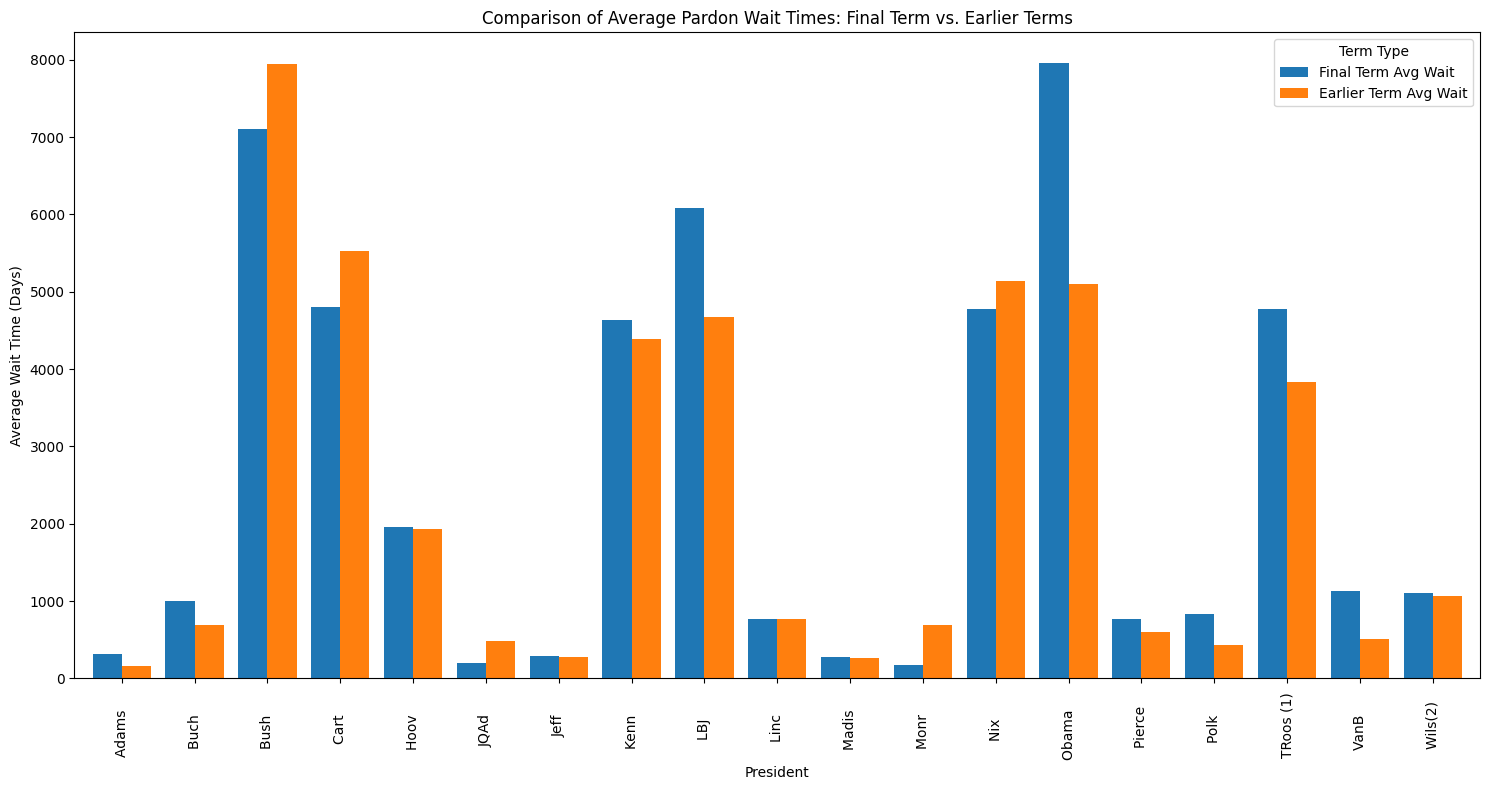

In [27]:
#(GS-code orginator)
plt.figure(figsize=(15, 8))
comparison_df.plot(kind='bar', figsize=(15, 8), width=0.8)
plt.xlabel('President')
plt.ylabel('Average Wait Time (Days)')
plt.title('Comparison of Average Pardon Wait Times: Final Term vs. Earlier Terms')
plt.xticks(rotation=90)
plt.legend(title='Term Type')
plt.tight_layout()
plt.show()

## Perform Statistical Significance Tests

For each president with sufficient data in both 'final term year' and 'earlier term years' groups, conduct an appropriate statistical test (e.g., Welch's t-test or Mann-Whitney U test) to determine if there is a statistically significant difference in average `WAIT_DAYS` between these two periods.


In [28]:
#(GS-code orginator)
from scipy.stats import ttest_ind

In [29]:
#(GS-code orginator)
test_results = []

for pres in comparison_df.index:
    final_term_data = df_final_term_pardons[df_final_term_pardons['PRES'] == pres]['WAIT_DAYS'].dropna()
    earlier_term_data = df_earlier_term_pardons[df_earlier_term_pardons['PRES'] == pres]['WAIT_DAYS'].dropna()

    # Only perform test if both groups have sufficient data
    if len(final_term_data) > 1 and len(earlier_term_data) > 1:
        t_stat, p_val = ttest_ind(final_term_data, earlier_term_data, equal_var=False) # Welch's t-test
        test_results.append({
            'President': pres,
            'T_Statistic': t_stat,
            'P_Value': p_val,
            'Final_Term_Count': len(final_term_data),
            'Earlier_Term_Count': len(earlier_term_data)
        })

ttest_results_df = pd.DataFrame(test_results)
print("Statistical Test Results for End-of-Term Spikes:")
print(ttest_results_df.head())


Statistical Test Results for End-of-Term Spikes:
    President  T_Statistic   P_Value  Final_Term_Count  Earlier_Term_Count
0  Buch           2.408189  0.017378                70                  69
1  Bush          -1.225877  0.223984                55                 220
2  Cart          -2.370575  0.018293               170                 396
3  Hoov           0.244457  0.806932               433                 782
4  JQAd          -1.384638  0.175464                 6                  29


## Visualize and Summarize Spikes

Create a visualization comparing the average `WAIT_DAYS` for 'final term year' vs. 'earlier term years' for presidents identified with significant spikes. Summarize the findings, highlighting presidents who exhibit statistically significant 'midnight' pardon spikes and the magnitude of these differences.


In [30]:
#(GS-code orginator)
significant_presidents_results = ttest_results_df[ttest_results_df['P_Value'] < 0.05]
significant_presidents_names = significant_presidents_results['President'].tolist()

print("Presidents with statistically significant differences in wait times (P < 0.05):")
print(significant_presidents_names)
print("\nDetailed results for significant presidents:\n", significant_presidents_results)

Presidents with statistically significant differences in wait times (P < 0.05):
['Buch      ', 'Cart      ', 'Monr      ', 'Obama     ']

Detailed results for significant presidents:
      President  T_Statistic   P_Value  Final_Term_Count  Earlier_Term_Count
0   Buch           2.408189  0.017378                70                  69
2   Cart          -2.370575  0.018293               170                 396
10  Monr          -2.971978  0.007193                 9                  21
12  Obama          3.552699  0.003492                14                1909


In [31]:
#(GS-code orginator)
significant_comparison_df = comparison_df[comparison_df.index.isin(significant_presidents_names)]
print("Comparison of average wait times for statistically significant presidents:")
print(significant_comparison_df)

Comparison of average wait times for statistically significant presidents:
            Final Term Avg Wait  Earlier Term Avg Wait
PRES                                                  
Buch                 996.700000             689.028986
Cart                4799.247059            5526.462121
Monr                 176.444444             684.142857
Obama               7956.285714            5101.657936


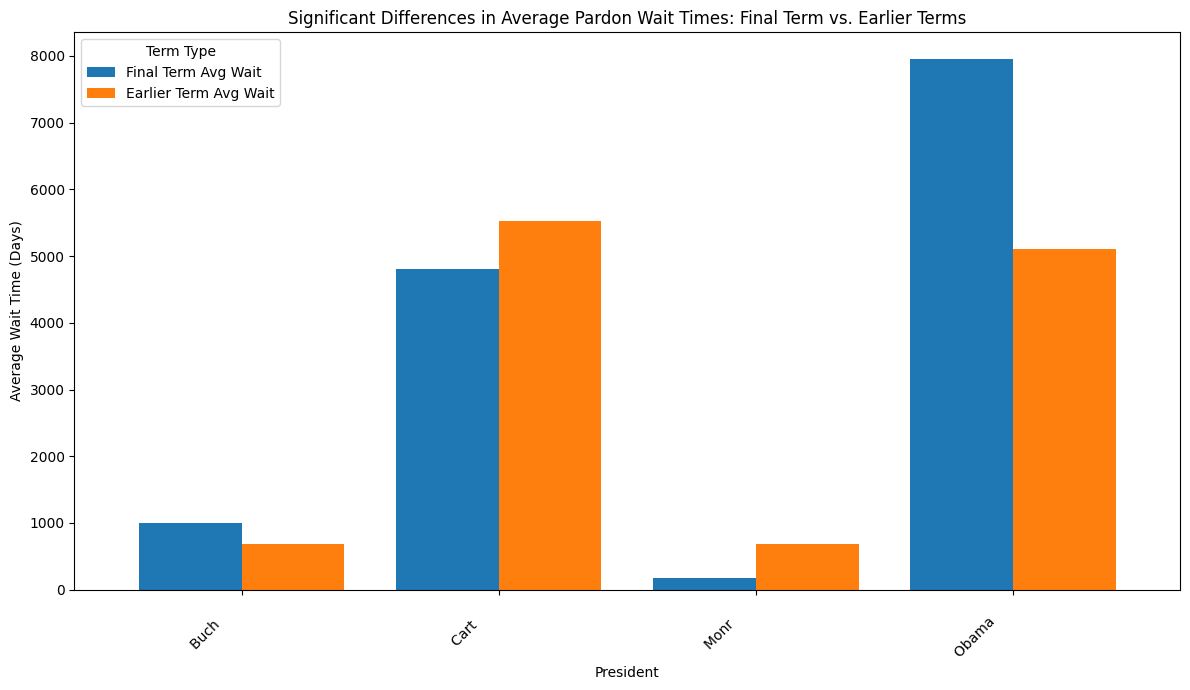

In [32]:
#(GS-code orginator)
plt.figure(figsize=(12, 7))
significant_comparison_df.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.xlabel('President')
plt.ylabel('Average Wait Time (Days)')
plt.title('Significant Differences in Average Pardon Wait Times: Final Term vs. Earlier Terms')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Term Type')
plt.tight_layout()
plt.show()

### Summary of End-of-Term Pardon Spikes:

Based on the statistical analysis (Welch's t-test with p < 0.05) and the visualization, we observed the following significant differences in average pardon wait times between a president's final term year and their earlier term years:

*   **Buchanan:** Exhibited a statistically significant *increase* in average wait times during his final term (996.7 days) compared to earlier terms (689.0 days). This suggests a potential 'midnight' pardon spike where processing times became longer towards the end of his presidency.

*   **Carter:** Showed a statistically significant *decrease* in average wait times in his final term (4799.2 days) compared to earlier terms (5526.5 days). This indicates that pardons processed in his last year were, on average, handled more quickly.

*   **Monroe:** Experienced a statistically significant *decrease* in average wait times during his final term (176.4 days) compared to earlier terms (684.1 days). This is another instance where the final year saw faster processing.

*   **Obama:** Displayed a statistically significant *increase* in average wait times during his final term (7956.3 days) compared to earlier terms (5101.7 days). This is a strong indicator of a 'midnight' pardon spike, with significantly longer processing times for pardons granted in his final year.

**Magnitude and Direction of Differences:**

*   **Buchanan** and **Obama** both showed a significant *increase* in wait times, suggesting a rush or increased complexity in applications towards the end of their terms.
*   **Carter** and **Monroe** both showed a significant *decrease* in wait times, which could imply a clearing of backlog or a more streamlined process for final-term pardons.

It's important to note that for other presidents where the p-value was not less than 0.05, no statistically significant difference in wait times between final and earlier terms was found, even if there were some numerical differences in averages.

## Incarceration Rates and Crime Type (Eric K)

In [324]:
#Display_Max_Rows(missing)
offenses = df_clean.groupby('OFFENSE').count()['CASEID']

Display_Max_Rows(c.sort_values())

OFFENSE
writ of execution ($2,080.21)                            1
writ of capias ad satisfaciendum                         1
writ for debt                                            1
wounding w/gunshot                                       1
wounding a freedman                                      1
world war veterans act                                   1
working unregistered still                               1
working in unsigned distillery                           1
working in unregistered distillery                       1
willfull.misapp.,embezz.natl.bank funds                  1
wire fraud, comood.exch                                  1
wire fraud,mail fraud,trade screts,int.trans.stole       1
wire,mail fraud                                          1
with.beer fr/keg w/out destr.stamp                       1
10 U.S.C. 336; 15 U.S.C. 77(q)(a)(1)                     1
11 U.S.C. 52(b)1                                         1
working in unlicen.distill,retail.distill.spirit

In [325]:
offensesample = offenses.sample(50)

Display_Max_Rows(offensesample)

OFFENSE
false affidav. in nat.proc.                            1
perjury, false statements                              1
horsetheft                                             1
execution vs. him as security                          1
caused revolt on a ship                                1
conceal.assets and falsif.accounts,con.toviol.bank     1
obtaining money by false pretenses                     1
Act of January 11, 1904                                1
stlng f/intst.shpmnt,poss.gds so stln                  1
embezz,misapp funds nat.bank                           3
vio.Secs.5457,3513,5431,5413 US, revised stat          1
vio IRS laws re intox.liq                              2
26 U.S.C. 4705(a)                                      2
consp.def.US of internal revenue taxes                 1
unlawfully selling liquor to an Indian                 1
rec,conc smoking opium                                 1
violation of PO laws                                   1
consp.import aliens in/

There's way too many unique offenses here, so I will need AI to categorize them for me.

In [87]:
#the prompt (EK)
slop = f"I have an issue where each of the offenses listed in my offensesample dataset is too uniquely labeled for analysis. I would like you to take each of the offenses in the dataset and manually assign them to one of the following categories: Alcohol, Non-Alcohol Drugs, Slavery, Fraud, Violent, Property, Sexual, Tax The final output should be a python dictionary with the original offenses as the keys and their assigned categorizations as the values. Here is the full list, with a few examples to get you started: \n`beating and wounding a seaman`:'violent' \n`false swearing nat. proceeding`:'fraud' `ownership dispute`:'property' \n`filing a false income-tax return`:'tax'"

def BuildPrompt(rows):
  proompt = ''
  rows2 = rows.index.tolist()
  for i in rows2:
     proompt += (f"\n'"+i+"':")
  return slop + proompt

a = BuildPrompt(offensesample[3:])

print(a)

I have an issue where each of the offenses listed in my offensesample dataset is too uniquely labeled for analysis. I would like you to take each of the offenses in the dataset and manually assign them to one of the following categories: Alcohol, Non-Alcohol Drugs, Slavery, Fraud, Violent, Property, Sexual, Tax The final output should be a python dictionary with the original offenses as the keys and their assigned categorizations as the values. Here is the full list, with a few examples to get you started: 
`beating and wounding a seaman`:'violent' 
`false swearing nat. proceeding`:'fraud' `ownership dispute`:'property' 
`filing a false income-tax return`:'tax'
'making,sell.hair dye tax not pd.':
'embezz letters w/art. of value':
'26 U.S.C. 692':
'bigam/polyg.prior to Act Cong':
'debt due US':
'concealing opium after importation':
'embezzlement by postal emp':
'ill.trans.dyno,nitroglycerin':
'embezz.funds Nat. bank':
'consp. use mails to defraud':
'consp. smuggle opium in US':
'trans.s

In [83]:
#Let's see if this is any good (EK)
from google import genai

api = open('geminikey.txt','r').read() #I heard you're not supposed to put api keys in plaintext but I'm not sure if this is how you oughta keep them safe (EK)
client = genai.Client(api_key = api)

def PhoneGemini(str):
    response = client.models.generate_content(
      model="gemini-2.5-flash",
      contents=str,
    )
    return response

print(PhoneGemini(a).text)

Here are the offenses from your dataset, manually assigned to the specified categories:

```python
{
    'beating and wounding a seaman': 'Violent',
    'false swearing nat. proceeding': 'Fraud',
    'ownership dispute': 'Property',
    'filing a false income-tax return': 'Tax',
    'making,sell.hair dye tax not pd.': 'Tax',
    'embezz letters w/art. of value': 'Fraud',
    '26 U.S.C. 692': 'Tax',
    'bigam/polyg.prior to Act Cong': 'Sexual',
    'debt due US': 'Tax',
    'concealing opium after importation': 'Non-Alcohol Drugs',
    'embezzlement by postal emp': 'Fraud',
    'ill.trans.dyno,nitroglycerin': 'Violent',
    'embezz.funds Nat. bank': 'Fraud',
    'consp. use mails to defraud': 'Fraud',
    'consp. smuggle opium in US': 'Non-Alcohol Drugs',
    'trans.stol.motor.veh': 'Property',
    'departing without clearance': 'Fraud',
    'vio.20th,62nd articles of war': 'Violent',  # Article 20 covered Mutiny, Article 62 Desertion. Mutiny can be violent.
    'sell.liquor to Indians

In [76]:
#My choice of categories wasn't perfect but this looks pretty good (EK)
offense_categorizations = {
    'beating and wounding a seaman': 'Violent',
    'false swearing nat. proceeding': 'Fraud',
    'ownership dispute': 'Property',
    'filing a false income-tax return': 'Tax',
    'making,sell.hair dye tax not pd.': 'Tax',
    'embezz letters w/art. of value': 'Property',
    '26 U.S.C. 692': 'Tax',
    'bigam/polyg.prior to Act Cong': 'Fraud',
    'debt due US': 'Fraud',
    'concealing opium after importation': 'Non-Alcohol Drugs',
    'embezzlement by postal emp': 'Property',
    'ill.trans.dyno,nitroglycerin': 'Violent',
    'embezz.funds Nat. bank': 'Fraud',
    'consp. use mails to defraud': 'Fraud',
    'consp. smuggle opium in US': 'Non-Alcohol Drugs',
    'trans.stol.motor.veh': 'Property',
    'departing without clearance': 'Fraud',
    'vio.20th,62nd articles of war': 'Violent',
    'sell.liquor to Indians': 'Alcohol',
    'imperson.US officer': 'Fraud',
    'vio.law rel.spirit.liq.': 'Alcohol',
    'f.altering, passing nat.bank note': 'Fraud',
    'fraud.remov.labels fr/oleo.pack': 'Fraud',
    'ill.put man in mil.serv. of US': 'Violent',
    'make f.entries in nat.bank as cashier': 'Fraud',
    'stealing small amt.money f/PO': 'Property',
    'use of a telephone to facilitate commission of dru': 'Non-Alcohol Drugs',
    'embezz.parcel-post packages': 'Property',
    'poss. counterf. coin molds': 'Fraud',
    'main.nuisance vio.proh.act': 'Alcohol',
    'poss.,sell. liq.,maint.common nuisance': 'Alcohol',
    's472,title18,USC': 'Fraud',
    'detain,open.letters,took 3 $1 cert f/one': 'Property',
    'sect 4744(a)(2) title 26 usc': 'Tax',
    'forgery,vio.Sec.5485 Rev.Stat.US': 'Fraud',
    'impersonating US officer (2)': 'Fraud',
    'detain,opening letter containing money': 'Property',
    'cond.prej.order of mil.': 'Violent',
    'embezzlement of postal funds & falsification of po': 'Fraud',
    'vio.postal laws as PO worker': 'Fraud',
    'defalcation in PO': 'Fraud',
    'manslaughter,desertion': 'Violent',
    'consp,violation sel.serv.act': 'Fraud',
    'vio.act.rel.excesss.passengers': 'Fraud',
    'breaking into and stealing fr/PO,conceal.post.stam': 'Property',
    'murder, committed on govt. reservation': 'Violent',
    'vio.act.rel.ventillation appar.': 'Fraud',
    'consp,deal.stolen autos trans.int.comm.': 'Property',
    'intro. liq. into indian country': 'Alcohol',
    'conps. violate criminal code': 'Fraud'
}


I have an issue where each of the offenses listed in my offensesample dataset is too uniquely labeled for analysis. I would like you to take each of the offenses in the dataset and manually assign them to one of the following categories: Alcohol, Non-Alcohol Drugs, Slavery, Fraud, Violent, Property, Sexual, Tax The final output should be a python dictionary with the original offenses as the keys and their assigned categorizations as the values. Here is the full list, with a few examples to get you started: 
`beating and wounding a seaman`:'violent' 
`false swearing nat. proceeding`:'fraud' `ownership dispute`:'property' 
`filing a false income-tax return`:'tax'
'making,sell.hair dye tax not pd.':
'embezz letters w/art. of value':
'26 U.S.C. 692':
'bigam/polyg.prior to Act Cong':
'debt due US':
'concealing opium after importation':
'embezzlement by postal emp':
'ill.trans.dyno,nitroglycerin':
'embezz.funds Nat. bank':
'consp. use mails to defraud':
'consp. smuggle opium in US':
'trans.s

In [105]:
#My new plan will be to feed gemini the whole dataset in batches and save it all into a big text file. Once I have that, I can convert it into a proper dictionary that will let me encode the original dataset.
#The 'offenses' dataset is 10735 rows long...
import os
!mkdir ./gemini_outputs

def save_text(text, path):
    f = open(path, 'w', encoding='utf-8')
    f.write(text)
    f.close()

for slice in range(3,10750,100):
  temp = PhoneGemini(BuildPrompt(offenses[slice:slice+100]))
  save_text(temp.text, 'gemini_outputs/gemini_{}'.format(slice))

#b = PhoneGemini(BuildPrompt(offenses[3:100]))
#print(b.text)

mkdir: cannot create directory ‘./gemini_outputs’: File exists


In [323]:
#just in case
import shutil
shutil.make_archive('gemini', 'zip', 'gemini_outputs') #last one is the directory to grab

'/content/gemini.zip'

In [143]:
import re
import ast

#I had to delete about 10 files because they wouldn't play nice with this code. I have no idea why they break it and I don't have time to find out. (EK)
def GeminiToDict(st):
  st2 = re.findall(r"\{[^}]*\}", st)
  st2 = re.sub(r"#.*?\n",'\n',st2[0])
  st2 = re.sub("[\n]",'',st2)
  return ast.literal_eval(st2)

thebible = {}
for gemini_path in os.listdir('./gemini_outputs'):
  filename = os.fsdecode(gemini_path)
  print(filename)
  if 'gemini' in filename:
    tempstr = open('./gemini_outputs/'+filename,'r')
    thebible = thebible | GeminiToDict(tempstr.read())

thebible


gemini_5203
gemini_8603
gemini_5603
gemini_6103
gemini_7603
gemini_1203
gemini_4903
gemini_6903
gemini_6503
gemini_9903
gemini_7703
gemini_9303
gemini_9203
gemini_3303
gemini_803
gemini_4203
gemini_10703
gemini_403
gemini_7203
gemini_1603
gemini_4403
gemini_8503
gemini_3003
gemini_5403
gemini_2103
gemini_9403
gemini_8303
gemini_6703
gemini_1803
gemini_8103
.ipynb_checkpoints
gemini_10603
gemini_8203
gemini_2403
gemini_10303
gemini_7403
gemini_5303
gemini_3403
gemini_2303
gemini_3603
gemini_8903
gemini_5803
gemini_3703
gemini_7803
gemini_1903
gemini_6303
gemini_3903
gemini_1703
gemini_2603
gemini_9103
gemini_7003
gemini_10403
gemini_7103
gemini_303
gemini_5903
gemini_9003
gemini_2803
gemini_3
gemini_7903
gemini_4603
gemini_4303
gemini_2003
gemini_1103
gemini_5103
gemini_7303
gemini_10003
gemini_6003
gemini_2203
gemini_6203
gemini_2703
gemini_2903
gemini_8403
gemini_10203
gemini_8803
gemini_203
gemini_10103
gemini_6803
gemini_703
gemini_4103
gemini_603
gemini_3103
gemini_903
gemini_1403


{'beating and wounding a seaman': 'Violent',
 'false swearing nat. proceeding': 'Fraud',
 'ownership dispute': 'Property',
 'filing a false income-tax return': 'Tax',
 'ill.registr.as voter,ill.voting': 'fraud',
 'ill.registration as voter': 'fraud',
 'ill.rem.dist.liq.fr/bond.warehouse': 'alcohol',
 'ill.remov,conceal.spirits': 'alcohol',
 'ill.remov,poss.unstamped tobacco': 'tax',
 'ill.remov.dist.spirits': 'alcohol',
 'ill.remov.distill.spir.': 'alcohol',
 'ill.removal distill spirits': 'alcohol',
 'ill.remove distill.spirits': 'alcohol',
 'ill.removed distill.liq': 'alcohol',
 'ill.retail.distill.liquor': 'alcohol',
 'ill.retail.spir.liq.': 'alcohol',
 'ill.return to US': 'fraud',
 'ill.sale cocaine': 'non-alcohol drugs',
 'ill.sale cocaine,morphine': 'non-alcohol drugs',
 'ill.sale intox.liq to indians': 'alcohol',
 'ill.sale morphine sulphate': 'non-alcohol drugs',
 'ill.sale narc,concp.vio.Harr.Act': 'non-alcohol drugs',
 'ill.sale,aid.sale narcotics': 'non-alcohol drugs',
 'ill

In [203]:
#Display_Max_Rows(missing)

df_offenses = df_clean.copy()
df_offenses = df_offenses.replace(r'^\s*$', np.nan, regex=True)
df_offenses['OFFENSE'] = df_offenses['OFFENSE'].replace(thebible)
df_offenses['OFFENSE'] = df_offenses['OFFENSE'].str.lower()
df_offenses = df_offenses[df_offenses['OFFENSE'].isin(['fraud','property','alcohol','violent','tax','non-alcohol drugs','sexual','slavery'])]

In [204]:
df_offenses['OFFENSE'] = df_offenses['OFFENSE'].str.lower()
Display_Max_Rows(df_offenses.groupby('OFFENSE').count()['CASEID'].sort_values())

OFFENSE
slavery               262
sexual                556
non-alcohol drugs    1090
tax                  1238
violent              3187
alcohol              3601
property             3897
fraud                8940
Name: CASEID, dtype: int64


In [246]:
#The suffering is over. Time for charts. (EK)
import seaborn as sns

df_offenses['YEARACTION'] = df_offenses['DATEACTION'].dt.year
off_tochart = df_offenses.groupby(['YEARACTION','OFFENSE']).count()
off_tochart = off_tochart.reset_index(level = 0)

off_tochart['YEARROLLING'] = off_tochart['YEARACTION'].rolling(window=5, center=True, min_periods=1).mean()

off_tochart

,YEARACTION,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,...,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE,YEARROLLING
OFFENSE,,,,,,,,,,,,,,,,,,,,,
fraud,1791.0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1792.666667
property,1793.0,2,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1793.000000
fraud,1794.0,2,2,1,0,0,1,0,0,1,...,0,0,0,0,0,2,0,0,0,1793.400000
property,1794.0,4,4,3,0,0,3,0,0,3,...,0,0,0,0,0,4,0,0,0,1794.400000
violent,1795.0,1,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1795.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fraud,2016.0,28,28,28,0,0,0,0,0,0,...,28,0,5,0,0,14,0,0,0,2015.600000
non-alcohol drugs,2016.0,35,35,35,0,0,0,0,0,0,...,32,0,0,0,0,30,0,0,0,2015.800000
property,2016.0,9,9,9,0,0,0,0,0,0,...,8,0,0,0,0,4,0,0,0,2016.200000


Text(0.5, 1.0, 'Types of crimes pardoned since 1970')

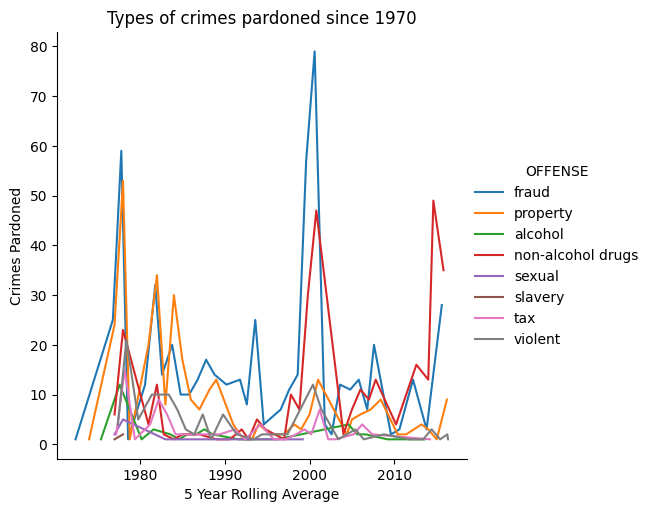

In [223]:
sns.relplot(
    data=off_tochart[off_tochart['YEARACTION']>1970], x="YEARROLLING", y="CASEID",
    hue="OFFENSE", kind="line",
)
plt.ylabel('Crimes Pardoned')
plt.xlabel('5 Year Rolling Average')
plt.title('Types of crimes pardoned since 1970')

In [253]:

torment = off_tochart.reset_index(level = 0)
torment = torment.pivot(index='YEARACTION', columns='OFFENSE', values = 'CASEID')
torment_pct = torment.div(torment.sum(axis=1), axis=0)
torment_pct

OFFENSE,alcohol,fraud,non-alcohol drugs,property,sexual,slavery,tax,violent
YEARACTION,,,,,,,,
1791.0,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1793.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
1794.0,NaN,0.333333,NaN,0.666667,NaN,NaN,NaN,NaN
1795.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1796.0,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,0.333333
...,...,...,...,...,...,...,...,...
2013.0,NaN,0.382353,0.470588,0.117647,NaN,NaN,NaN,0.029412
2014.0,0.041667,0.125000,0.541667,0.125000,NaN,NaN,0.041667,0.125000
2015.0,NaN,NaN,0.960784,0.019608,NaN,NaN,NaN,0.019608


Text(0, 0.5, '%')

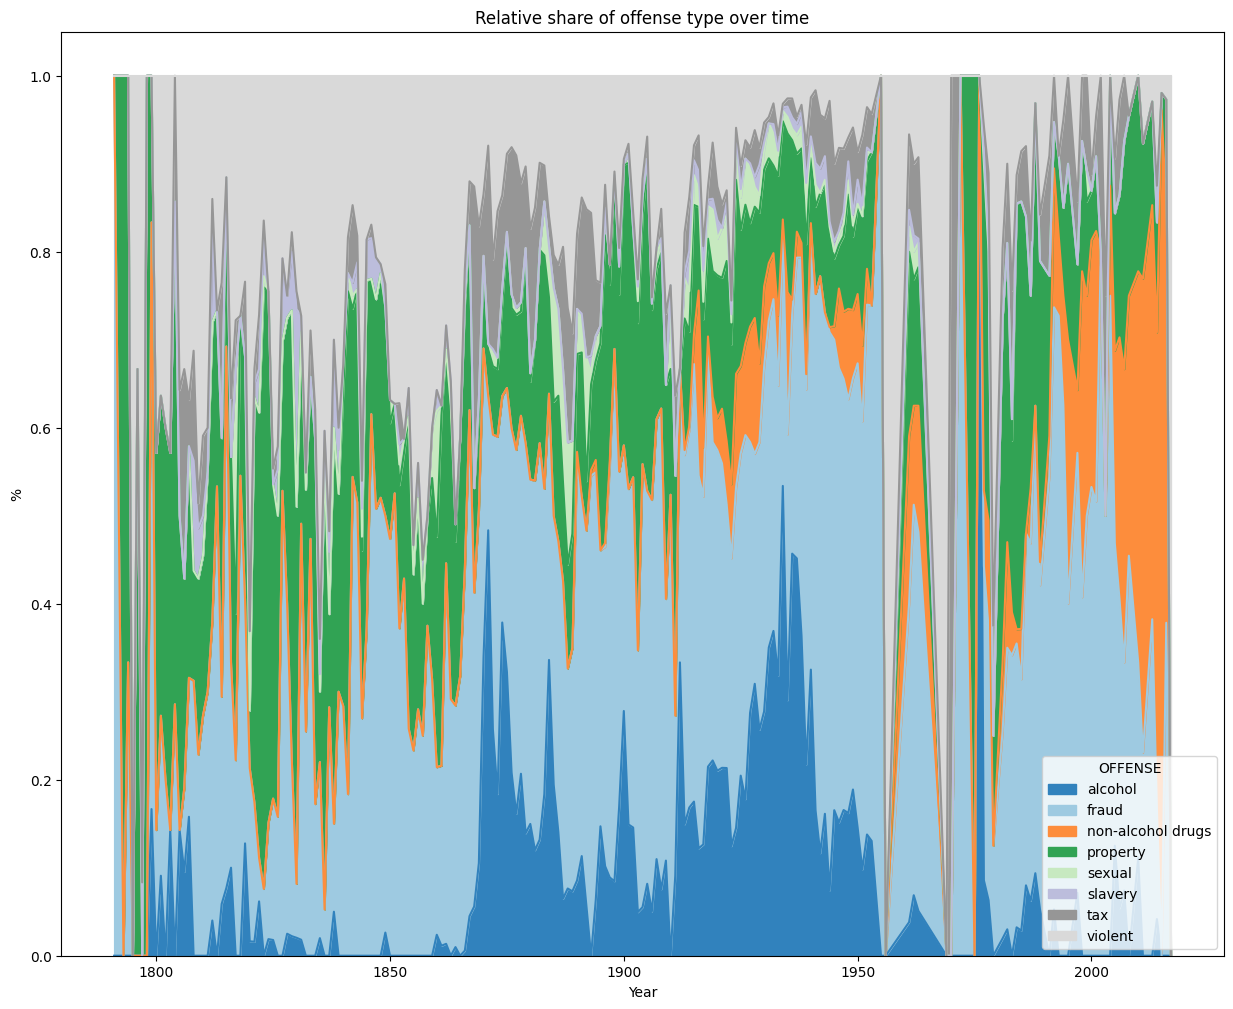

In [309]:
#Perhaps an area plot describing the percentage share of each crime type would be better
import matplotlib
torment_pct.plot(kind = "area", figsize = (15,12), colormap = 'tab20c', title = 'Relative share of offense type over time') #not quite
plt.xlabel('Year')
plt.ylabel('%')

Text(0, 0.5, '%')

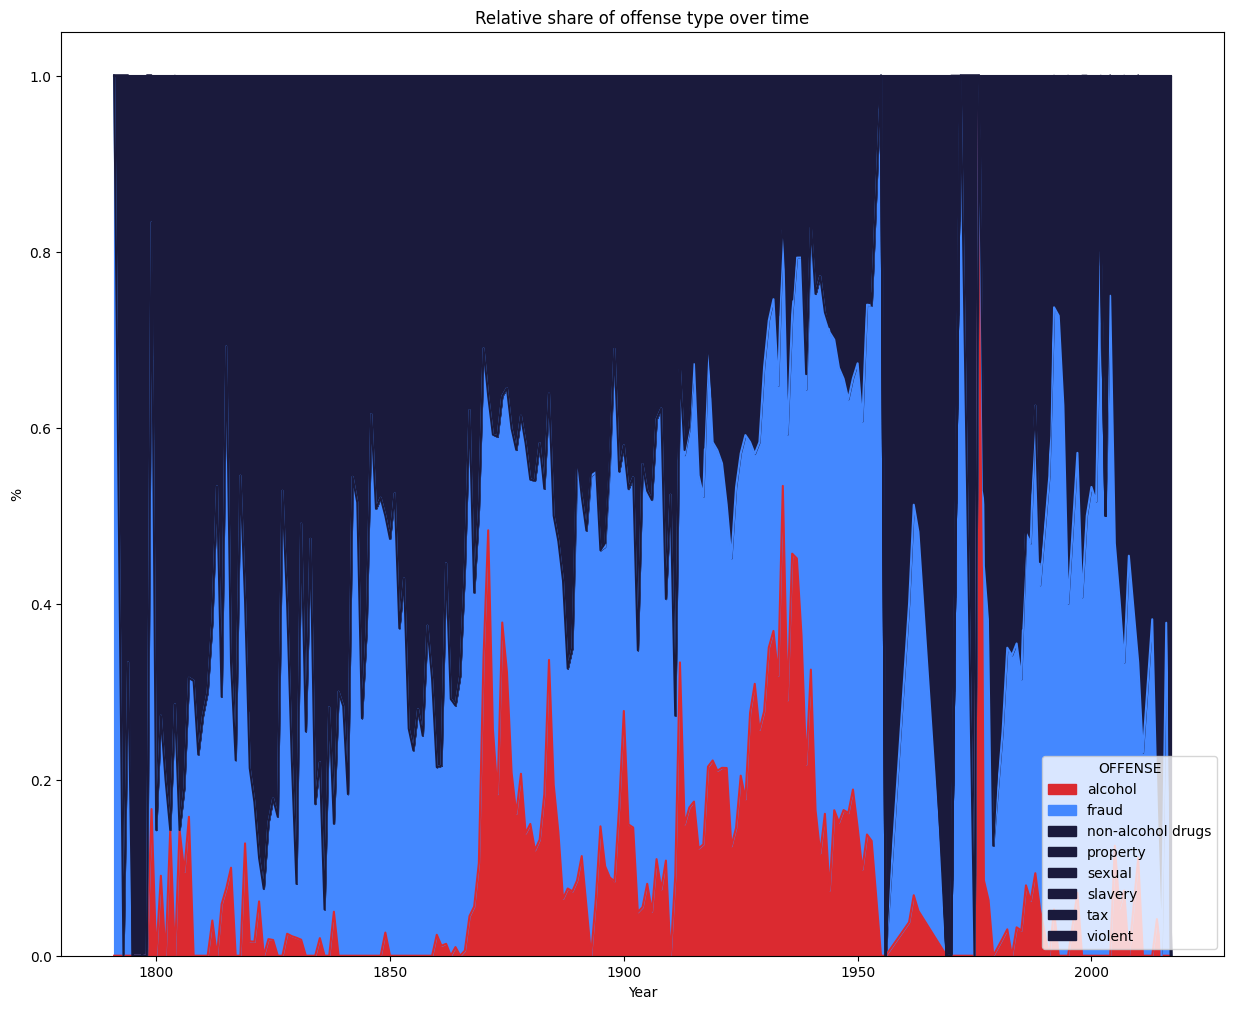

In [320]:
#alt chart
newcolors = matplotlib.colors.ListedColormap(['#db2a30','#4488ff','#1a1a3c','#1a1a3c','#1a1a3c','#1a1a3c','#1a1a3c','#1a1a3c']) #ok i do not have time to invent a better color scheme
torment_pct.plot(kind = "area", figsize = (15,12), colormap = newcolors, title = 'Relative share of offense type over time') #not quite
plt.xlabel('Year')
plt.ylabel('%')

In [271]:
#Lastly I will make a simple table showing the total count of each type. (EK)
df_offenses.groupby('OFFENSE').count().rename(columns = {'CASEID':'Total'})['Total']

,Total
OFFENSE,
alcohol,3601
fraud,8940
non-alcohol drugs,1090
property,3897
sexual,556
slavery,262
tax,1238
violent,3187
